In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from itertools import combinations
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error
import keras
from scipy.stats import zscore
pd.set_option("display.max_rows",800)

In [11]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [12]:
import pandas as pd
class Battery(object):
    def __init__(self,matfile,batname):
        self.matfile=matfile
        self.batname=batname
        self.file=scipy.io.loadmat(self.matfile)
        self.bat=pd.DataFrame(self.file[self.matfile[0:-4]]['cycle'][0][0][0])
    
    def remove_double_type(self):
        types_list=self.file[self.matfile[0:-4]]['cycle'][0][0]['type']
        for i in range(len(types_list[0])-1):
            if types_list[0][i][0]==types_list[0][i+1][0]:
                self.bat.drop(index=i,inplace=True)
            else:
                pass
    
    def Charging_Data(self):
        self.bat_charge=self.bat[self.bat['type']=='charge']
        self.bat_charge.index=range(len(self.bat_charge['type']))
        
        self.bat_discharge=self.bat[self.bat['type']=='discharge']
        self.bat_discharge.index=range(len(self.bat_discharge['type']))
        
        if len(self.bat_charge['type'])!=len(self.bat_discharge['type']):
            self.bat_charge=self.bat_charge.iloc[0:min(len(self.bat_charge['type']),len(self.bat_discharge['type'])),:]
            self.bat_discharge=self.bat_discharge.iloc[0:min(len(self.bat_charge['type']),len(self.bat_discharge['type'])),:]
        
        
        temp_data=pd.DataFrame(columns=range(31))
        for i in range(len(self.bat_charge['type'])):
            x=len(self.bat_charge['data'][i]['Voltage_measured'][0][0][0])
            e=np.mod(x,10)
            V=self.bat_charge['data'][i]['Voltage_measured'][0][0][:,0:x-e].T
            l=len(V)//10
            #V.resize(l,10)
            V.resize(10,l)
            V=V.T
            V=np.mean(V,axis=0)
            
            x=len(self.bat_charge['data'][i]['Current_measured'][0][0][0])
            e=np.mod(x,10)
            C=self.bat_charge['data'][i]['Current_measured'][0][0][:,0:x-e].T
            l=len(C)//10
            #C.resize(l,10)
            C.resize(10,l)
            C=C.T
            C=np.mean(C,axis=0)
            
            x=len(self.bat_charge['data'][i]['Temperature_measured'][0][0][0])
            e=np.mod(x,10)
            T=self.bat_charge['data'][i]['Temperature_measured'][0][0][:,0:x-e].T
            l=len(T)//10
            #T.resize(l,10)
            T.resize(10,l)
            T=T.T
            T=np.mean(T,axis=0)
            
            
            Cap=self.bat_discharge['data'][i]['Capacity'][0][0][0]
            
            VCT=np.concatenate((V,C,T,Cap),axis=0)
            
            temp_data.loc[i,:]=VCT
        temp_data=pd.DataFrame(temp_data.astype('float64'))
        temp_data.insert(loc=0,column='Battery Name',value=self.batname,allow_duplicates=True)
        self.bat_char_profile=temp_data

In [13]:
Bat5=Battery('B0005.mat','B5')
Bat5.remove_double_type()
Bat5.Charging_Data()

In [14]:
Bat6=Battery('B0006.mat','B6')
Bat6.remove_double_type()
Bat6.Charging_Data()

In [15]:
Bat7=Battery('B0007.mat','B7')
Bat7.remove_double_type()
Bat7.Charging_Data()

In [16]:
Bat18=Battery('B0018.mat','B18')
Bat18.remove_double_type()
Bat18.Charging_Data()

In [17]:
Bat5.bat_char_profile=Bat5.bat_char_profile.iloc[1:-1,:]
Bat6.bat_char_profile=Bat6.bat_char_profile.iloc[1:-1,:]
Bat7.bat_char_profile=Bat7.bat_char_profile.iloc[1:-1,:]
Bat18.bat_char_profile=Bat18.bat_char_profile.iloc[1:,:]



In [18]:
b1=Bat5.bat_char_profile.iloc[:,1:11]
b2=Bat6.bat_char_profile.iloc[:,1:11]
b3=Bat7.bat_char_profile.iloc[:,1:11]
b4=Bat18.bat_char_profile.iloc[:,1:11]

scaler_b1=MinMaxScaler()
scaler_b2=MinMaxScaler()
scaler_b3=MinMaxScaler()
scaler_b4=MinMaxScaler()

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

b1=pd.DataFrame(scaler_b1.fit_transform(b1))
b2=pd.DataFrame(scaler_b2.fit_transform(b2))
b3=pd.DataFrame(scaler_b3.fit_transform(b3))
b4=pd.DataFrame(scaler_b4.fit_transform(b4))

b1=b1.T
b2=b2.T
b3=b3.T
b4=b4.T

In [19]:
Dataset=pd.concat((Bat5.bat_char_profile,
                  Bat6.bat_char_profile,
                  Bat7.bat_char_profile,
                  Bat18.bat_char_profile),axis=0)
Dataset.index=range(len(Dataset['Battery Name']))
new_data=pd.concat((b1,b2,b3,b4),axis=0)
new_data.index=Dataset.index

In [20]:
y=Dataset.iloc[:,-1].values.reshape(-1,1)
scaler_y=MinMaxScaler(feature_range=(0,1))
y=scaler_y.fit_transform(y)
y=pd.DataFrame(y)

In [21]:
Single_Data=pd.concat((Dataset['Battery Name'],new_data,y),axis=1)

In [22]:
z=pd.DataFrame(np.abs(zscore(Single_Data.iloc[:,1:])))
Single_Data=Single_Data[(z <3).all(axis=1)]

Feedforward Neural Network

In [23]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LeakyReLU
from keras.layers import Dropout

In [24]:
Capacity={'B5':[],'B6':[],'B7':[],'B18':[],}

def Single_Channel_Training(model,battery=['B5','B6','B7','B18']):
    cv=list(combinations(battery,3))
    RMSE=[]
    MAE=[]
    MAPE=[]
    for i in cv:
        i=list(i)
        Test=[x for x in battery if x not in i]
        test_data=Single_Data[Single_Data['Battery Name']==Test[0]]
        train_data=Single_Data[Single_Data['Battery Name']!=Test[0]]
        X_train=train_data.iloc[:,1:11]
        y_train=train_data.iloc[:,-1].values.reshape(-1,1)
        X_test=test_data.iloc[:,1:11]
        y_test=test_data.iloc[:,-1].values.reshape(-1,1)
        
        model.fit(X_train,y_train,batch_size=50,epochs=500,verbose=0,validation_split=0.1)
        
        y_pred=model.predict(X_test)
        y_pred=scaler_y.inverse_transform(y_pred)
        y_test=scaler_y.inverse_transform(y_test)
        
        rmse=np.sqrt(mean_squared_error(y_test,y_pred))
        mae=mean_absolute_error(y_test,y_pred)
        mape=mean_absolute_percentage_error(y_test,y_pred)
        
        RMSE.append(rmse)
        MAE.append(mae)
        MAPE.append(mape)
        
        Capacity[Test[0]].append(y_pred)
    
    return np.mean(RMSE),np.mean(MAE),np.mean(MAPE)


(0.05832696469071273, 0.046677768080153094, 2.88762374842488)


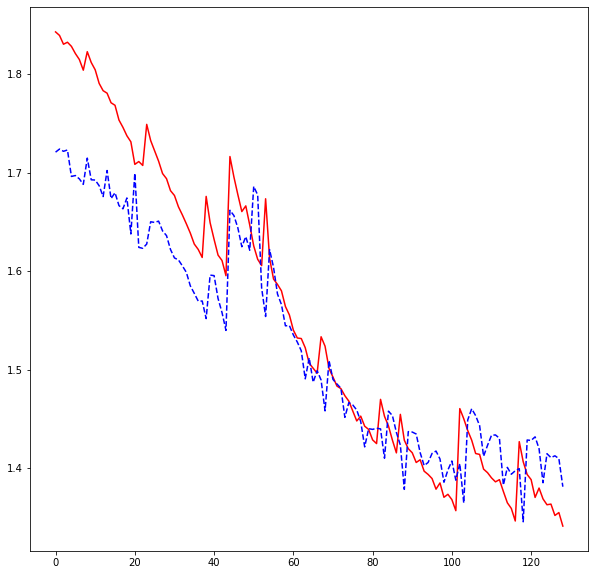

(0.06009204232229307, 0.05173864331514499, 3.304553598712149)


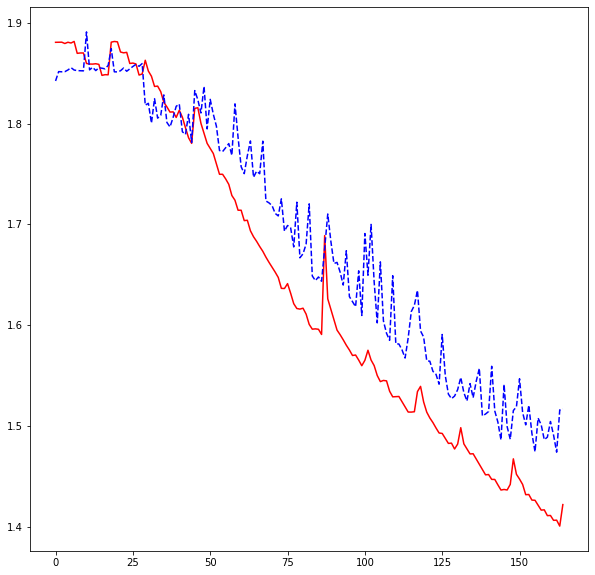

(0.08124828849527985, 0.06973778914038316, 4.491212891062002)


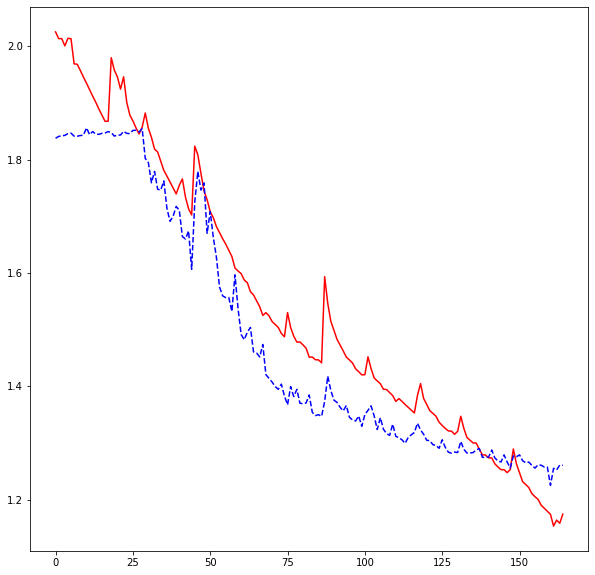

(0.05149402064478923, 0.041505297007333596, 2.6702001143729506)


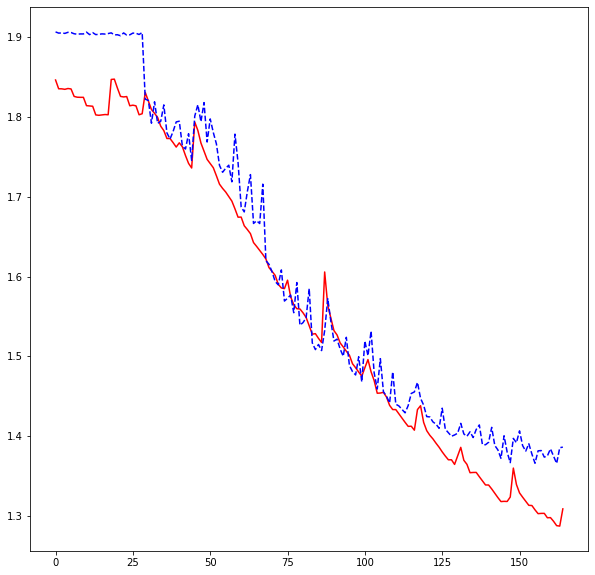

(0.06279032903826873, 0.052414874385753714, 3.3383975881429953)

In [25]:
FNN1=Sequential()
FNN1.add(Dense(units = 10, kernel_initializer = 'normal', input_dim = 10))
FNN1.add(LeakyReLU(alpha=0.1))
FNN1.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))
FNN1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
FNN1.optimizer.learning_rate = 0.001

rmse_1,mae_1,mape_1=Single_Channel_Training(FNN1)
(rmse_1,mae_1,mape_1)

(0.05746556961068777, 0.046901533685252454, 2.927421480506031)


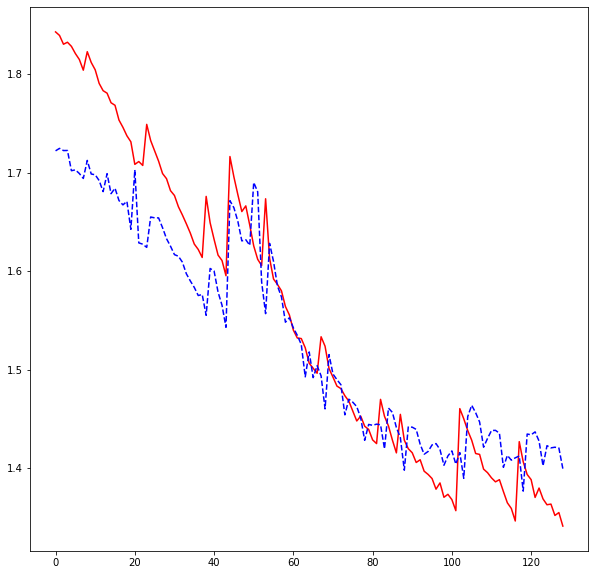

(0.07343244359839318, 0.06619646665471857, 4.2021796568529775)


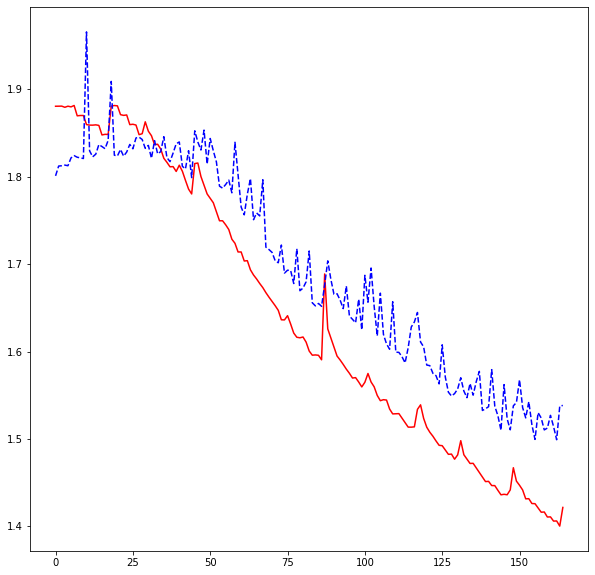

(0.1003475259404937, 0.08934468277606385, 5.775023721921221)


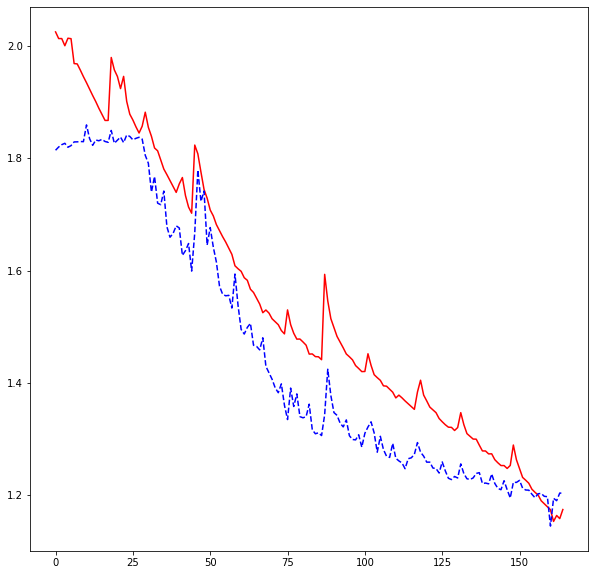

(0.07330540517787962, 0.05838794613036374, 3.9200718813122695)


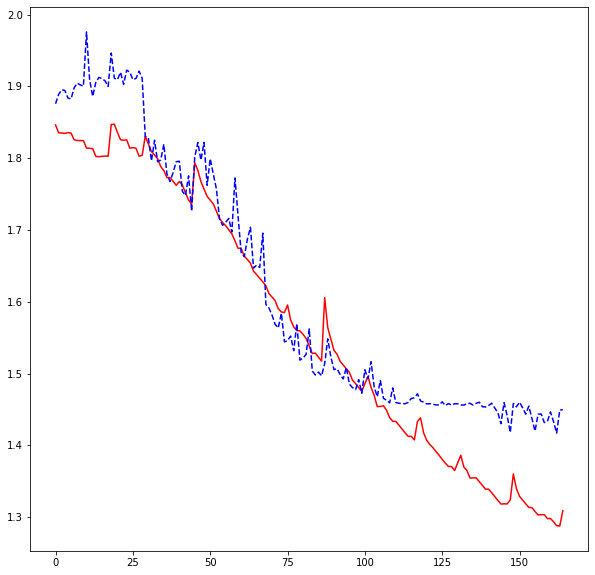

(0.07613773608186357, 0.06520765731159965, 4.206174185148125)

In [26]:
FNN2=Sequential()
FNN2.add(Dense(units = 40, kernel_initializer = 'normal', input_dim = 10))
FNN2.add(LeakyReLU(alpha=0.1))
FNN2.add(Dropout(0.2))
FNN2.add(Dense(units = 1, kernel_initializer = 'normal', activation = 'linear'))
FNN2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
FNN2.optimizer.learning_rate = 0.001

rmse_2,mae_2,mape_2=Single_Channel_Training(FNN2)
(rmse_2,mae_2,mape_2)

Convolutional Neural Network

In [29]:
import keras
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

In [30]:
def Single_Channel_Training_CNN(model,battery=['B5','B6','B7','B18']):
    cv=list(combinations(battery,3))
    RMSE=[]
    MAE=[]
    MAPE=[]
    for i in cv:
        i=list(i)
        Test=[x for x in battery if x not in i]
        test_data=Single_Data[Single_Data['Battery Name']==Test[0]]
        train_data=Single_Data[Single_Data['Battery Name']!=Test[0]]
        X_train=train_data.iloc[:,1:11]
        X_train=X_train.values.reshape((len(X_train.index),len(X_train.columns),1,1))
        y_train=train_data.iloc[:,-1].values.reshape(-1,1)
        X_test=test_data.iloc[:,1:11]
        X_test=X_test.values.reshape((len(X_test.index),len(X_test.columns),1,1))
        y_test=test_data.iloc[:,-1].values.reshape(-1,1)
        
        
        model.fit(X_train,y_train,batch_size=50,epochs=500,verbose=0)
        
        y_pred=model.predict(X_test)
        y_pred=scaler_y.inverse_transform(y_pred)
        y_test=scaler_y.inverse_transform(y_test)
        
        rmse=np.sqrt(mean_squared_error(y_test,y_pred))
        mae=mean_absolute_error(y_test,y_pred)
        mape=mean_absolute_percentage_error(y_test,y_pred)
        
        RMSE.append(rmse)
        MAE.append(mae)
        MAPE.append(mape)
        
        Capacity[Test[0]].append(y_pred)
    
    return np.mean(RMSE),np.mean(MAE),np.mean(MAPE)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 10, 1, 10)         30        
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 10, 1, 10)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 1, 5)          105       
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 10, 1, 5)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 50)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 51        
Total params: 186
Trainable params: 186
Non-trainable params: 0
________________________________________________________

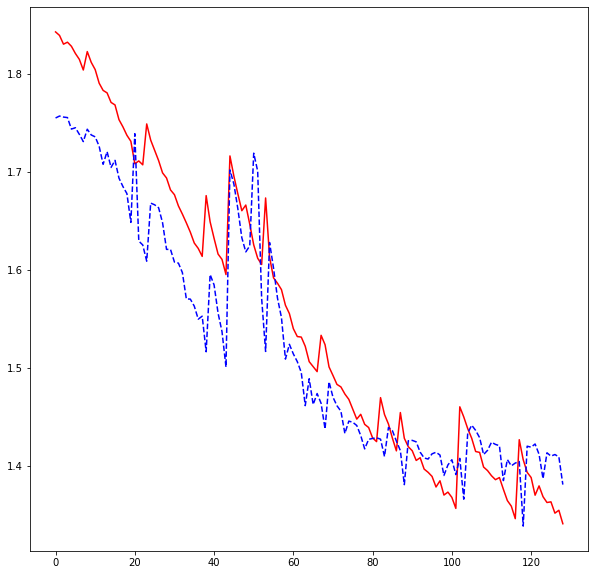

(0.058276823267760125, 0.05065303124786735, 3.211424272625281)


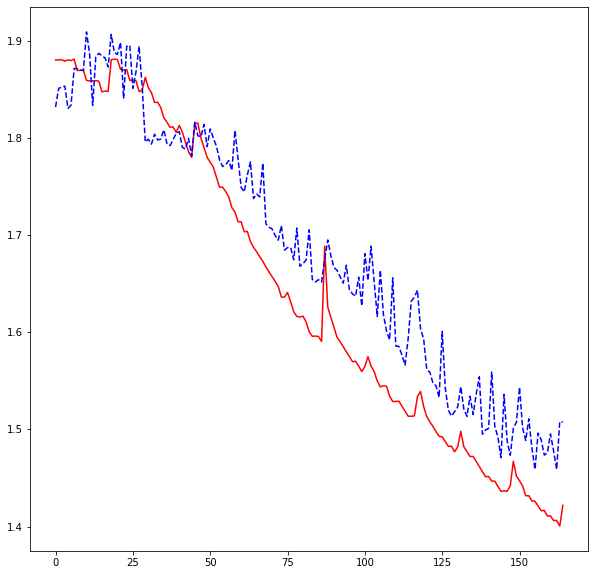

(0.07576064003226125, 0.06415276758023324, 4.098033150232001)


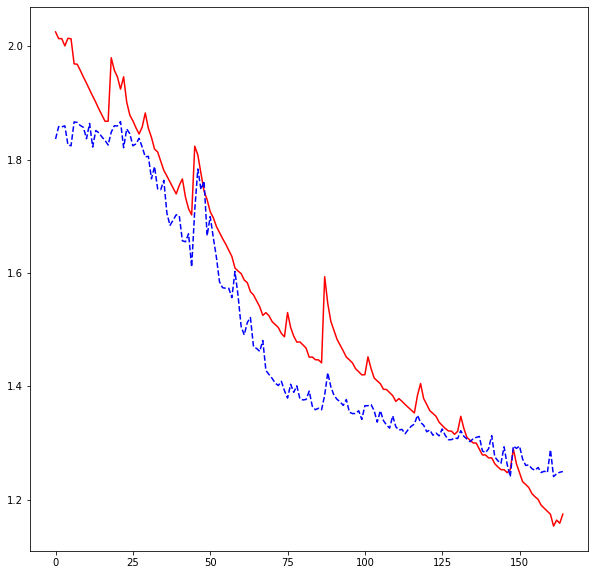

(0.04889576078596372, 0.039604713228005746, 2.530270150474671)


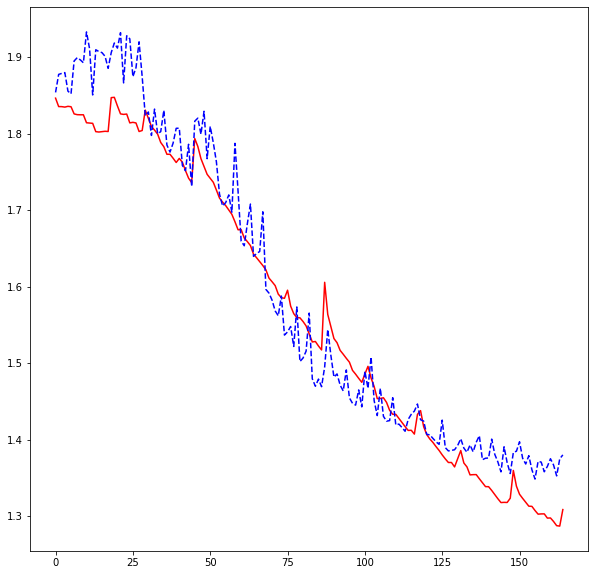

In [31]:
CNN1=Sequential()
CNN1.add(Conv2D(filters=10,kernel_size=(1,2),kernel_initializer='normal',input_shape=(10,1,1),padding='same'))
CNN1.add(LeakyReLU(alpha=0.1))
CNN1.add(Conv2D(filters=5,kernel_size=(1,2),kernel_initializer='normal',padding='same'))
CNN1.add(LeakyReLU(alpha=0.1))
CNN1.add(Flatten())
CNN1.add(Dense(units=1,activation='linear'))
CNN1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
CNN1.summary()
rmse_3,mae_3,mape_3=Single_Channel_Training_CNN(CNN1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 10, 1, 30)         90        
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 10, 1, 30)         0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 1, 30)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 1, 15)         915       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 1, 15)         0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 1, 15)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 150)              

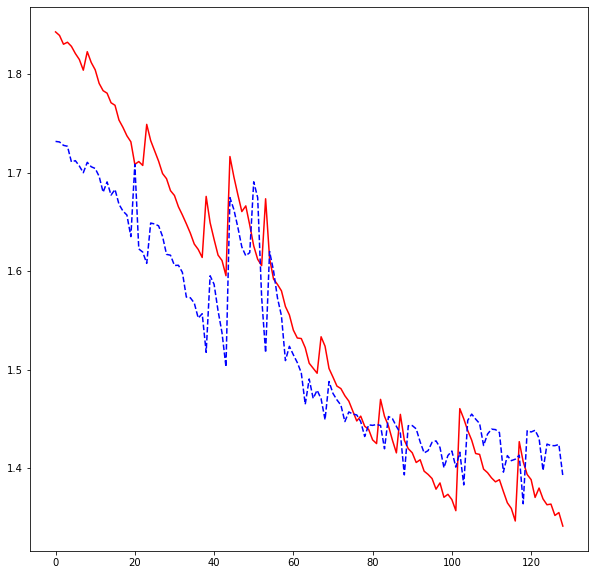

(0.04931405638787932, 0.043168351992527186, 2.743044576556921)


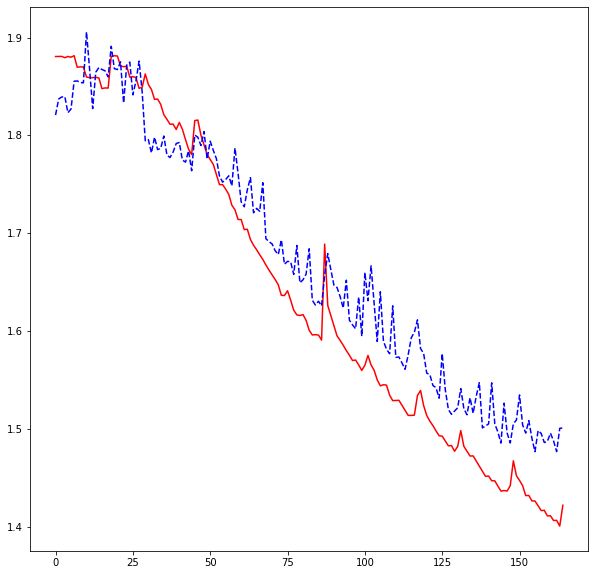

(0.07948785753448306, 0.06971819239804129, 4.4105213389485804)


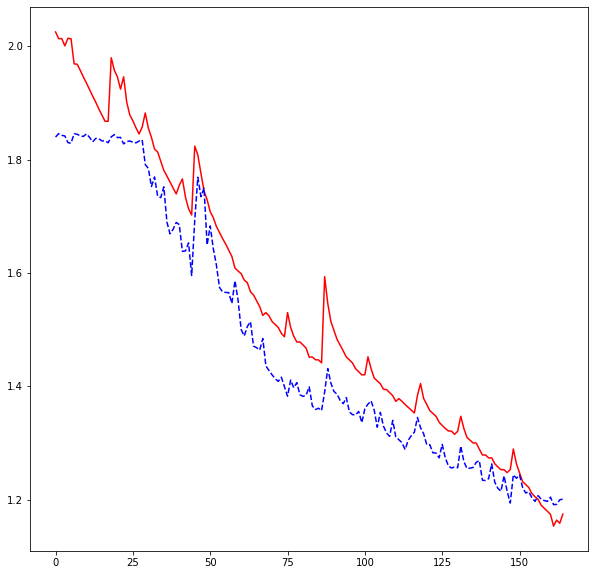

(0.05482941202049264, 0.04565183367797769, 2.9840837742279955)


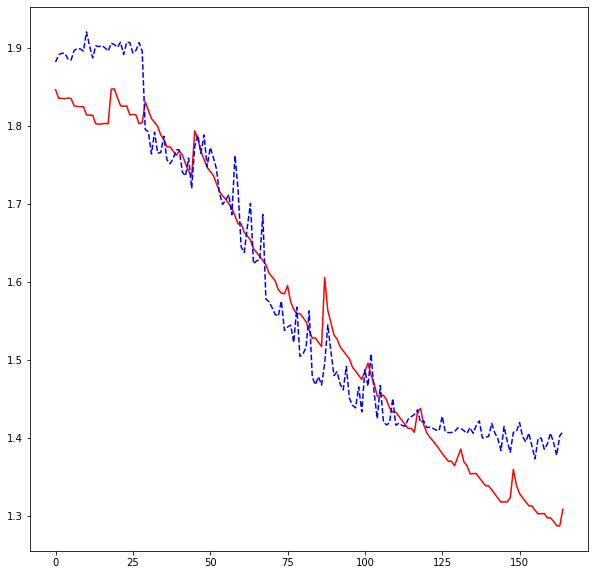

In [32]:
CapacityN2=Sequential()
CNN2.add(Conv2D(filters=30,kernel_size=(1,2),kernel_initializer='normal',input_shape=(10,1,1),padding='same'))
CNN2.add(LeakyReLU(alpha=0.1))
CNN2.add(Dropout(0.2))
CNN2.add(Conv2D(filters=15,kernel_size=(1,2),kernel_initializer='normal',padding='same'))
CNN2.add(LeakyReLU(alpha=0.1))
CNN2.add(Dropout(0.2))
CNN2.add(Flatten())
CNN2.add(Dense(units=1,activation='linear'))
CNN2.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
CNN2.summary()
rmse_4,mae_4,mape_4=Single_Channel_Training_CNN(CNN2)

In [111]:
import keras
from keras.models import Sequential
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import LSTM

In [17]:
battery_5_lstm_X=[]
battery_6_lstm_X=[]
battery_7_lstm_X=[]
battery_18_lstm_X=[]

battery_5_lstm_y=[]
battery_6_lstm_y=[]
battery_7_lstm_y=[]
battery_18_lstm_y=[]


b1=h[h['Battery Name']=='B5'].iloc[:,1:12].values
b2=h[h['Battery Name']=='B6'].iloc[:,1:12].values
b3=h[h['Battery Name']=='B7'].iloc[:,1:12].values
b4=h[h['Battery Name']=='B18'].iloc[:,1:12].values

for i in range(5, b1.shape[0]):
    battery_5_lstm_X.append(b1[i-5:i,0:11])
    battery_5_lstm_y.append(b1[i,-1])
battery_5_lstm_X, battery_5_lstm_y = np.array(battery_5_lstm_X), np.array(battery_5_lstm_y)

for i in range(5, b2.shape[0]):
    battery_6_lstm_X.append(b2[i-5:i,0:11])
    battery_6_lstm_y.append(b2[i,-1])
battery_6_lstm_X, battery_6_lstm_y = np.array(battery_6_lstm_X), np.array(battery_6_lstm_y)

for i in range(5, b3.shape[0]):
    battery_7_lstm_X.append(b3[i-5:i,0:11])
    battery_7_lstm_y.append(b3[i, -1])
battery_7_lstm_X, battery_7_lstm_y = np.array(battery_7_lstm_X), np.array(battery_7_lstm_y)

for i in range(5, b4.shape[0]):
    battery_18_lstm_X.append(b4[i-5:i,0:11])
    battery_18_lstm_y.append(b4[i, -1])
battery_18_lstm_X, battery_18_lstm_y = np.array(battery_18_lstm_X), np.array(battery_18_lstm_y)

In [19]:
LSTM1=Sequential()
LSTM1.add(LSTM(units=55,return_sequences=False,input_shape=((5,11))))
LSTM1.add(LeakyReLU(alpha=0.1))
LSTM1.add(Dense(units=1))
LSTM1.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = ['accuracy'])
LSTM1.optimizer.learning_rate = 0.001
LSTM1.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 55)                14740     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 55)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 56        
Total params: 14,796
Trainable params: 14,796
Non-trainable params: 0
_________________________________________________________________


In [20]:
Training_X=np.concatenate((battery_5_lstm_X,battery_6_lstm_X,battery_7_lstm_X))
Training_y=np.concatenate((battery_5_lstm_y,battery_6_lstm_y,battery_7_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_18_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_18_lstm_y.reshape(-1,1))
rmse18=np.sqrt(mean_squared_error(y_test,y_pred))
mae18=mean_absolute_error(y_test,y_pred)
mape18=mean_absolute_percentage_error(y_test,y_pred)

lstm18=y_pred

In [21]:
Training_X=np.concatenate((battery_5_lstm_X,battery_6_lstm_X,battery_18_lstm_X))
Training_y=np.concatenate((battery_5_lstm_y,battery_6_lstm_y,battery_18_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_7_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_7_lstm_y.reshape(-1,1))
rmse7=np.sqrt(mean_squared_error(y_test,y_pred))
mae7=mean_absolute_error(y_test,y_pred)
mape7=mean_absolute_percentage_error(y_test,y_pred)

lstm7=y_pred

In [22]:
Training_X=np.concatenate((battery_5_lstm_X,battery_18_lstm_X,battery_7_lstm_X))
Training_y=np.concatenate((battery_5_lstm_y,battery_18_lstm_y,battery_7_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_6_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_6_lstm_y.reshape(-1,1))
rmse6=np.sqrt(mean_squared_error(y_test,y_pred))
mae6=mean_absolute_error(y_test,y_pred)
mape6=mean_absolute_percentage_error(y_test,y_pred)

lstm6=y_pred

In [23]:
Training_X=np.concatenate((battery_18_lstm_X,battery_6_lstm_X,battery_7_lstm_X))
Training_y=np.concatenate((battery_18_lstm_y,battery_6_lstm_y,battery_7_lstm_y))
LSTM1.fit(Training_X,Training_y,batch_size=50,epochs=500,verbose=0)
y_pred=LSTM1.predict(battery_5_lstm_X)
y_pred=scaler_y.inverse_transform(y_pred)
y_test=scaler_y.inverse_transform(battery_5_lstm_y.reshape(-1,1))
rmse5=np.sqrt(mean_squared_error(y_test,y_pred))
mae5=mean_absolute_error(y_test,y_pred)
mape5=mean_absolute_percentage_error(y_test,y_pred)

lstm5=y_pred

In [51]:
#file=open('Predicted Capacity','rb')

In [52]:
#import pickle
#Capacity=pickle.load(file)

In [57]:
#file.close()

In [54]:
#Capacity['B5'].append(lstm5)

In [55]:
#Capacity['B6'].append(lstm6)
#Capacity['B7'].append(lstm7)
#Capacity['B18'].append(lstm18)

In [67]:
'''
rmse_5=[]
rmse_5.append(rmse5)
rmse_5.append(rmse6)
rmse_5.append(rmse7)
rmse_5.append(rmse18)
rmse_5=np.mean(rmse_5)
'''

In [70]:
'''
mae_5=[]
mae_5.append(mae5)
mae_5.append(mae6)
mae_5.append(mae7)
mae_5.append(mae18)
mae_5=np.mean(mae_5)
'''

In [71]:
'''mape_5=[]
mape_5.append(mape5)
mape_5.append(mape6)
mape_5.append(mape7)
mape_5.append(mape18)
mape_5=np.mean(mape_5)'''

In [88]:
#Results=pd.read_csv('Single_Channel_Results')

In [90]:
#Results.iloc[4,:]=['LSTM',rmse_5,mae_5,mape_5]

In [92]:
#Results.columns=['Model','RMSE','MAE','MAPE(%)']

In [94]:
#file=open('Predicted Capacity','wb')

In [95]:
#import pickle

In [96]:
#pickle.dump(Capacity,file)

In [97]:
#file.close()

In [98]:
#Results.to_csv('Single_Channel_Results')